<a href="https://colab.research.google.com/github/erikjskie/ensemblemerge/blob/main/EnsembleMerge_Example_Vignette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## set environment

Additional packages have been installed for analysis
EnsembleMerge can be installed with: 
```

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("SingleCellExperiment", "SummarizedExperiment", "LoomExperiment"))
install.packages("Seurat")
devtools::install_github('theislab/kBET')
devtools::install_github('satijalab/seurat-wrappers')
devtools::install_github("cellgeni/sceasy")

```


 
package from bioconductor but to have access to: 
* Harmony
* bbknn
* scVI
* Scanorama
you will need to install those packages independently through pip and devtools as they are not available in cran

In [ ]:
### install R packages ###
install.packages("devtools")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("SummarizedExperiment", "SingleCellExperiment", "knitr", "LoomExperiment", "batchelor"))
devtools::install_github("immunogenomics/harmony")
devtools::install_github('theislab/kBET')
devtools::install_version("Seurat", version = "4.0.1")
remotes::install_github('satijalab/seurat-wrappers@66e6e5096e1d6291cb5a735f3e266336c16e80c4')
devtools::install_github("cellgeni/sceasy")
install.packages("rliger")
remotes::install_github("rstudio/reticulate")
install.packages("SparseM")
install.packages("ArgumentCheck")
install.packages("ggpubr")
### load in python packages (if not installed, can be installed by package)
system("pip3 install scanpy")
system("pip3 install scanorama")
system("pip3 install bbknn")
system("pip3 install pynndescent")
system("pip3 install leidenalg")
system("pip3 install scvi-tools")
remotes::install_github("rstudio/reticulate")
devtools::install_github("erikjskie/ensemblemerge", force = FALSE)
devtools::install_github('gongx030/scmetrics@b26a37c7e8b2f50b58f7b14e7f4748a805a1cf80', quiet = FALSE, ref = 'master')
devtools::reload(pkgload::inst("scmetrics"))

In [ ]:
## load packages
library(ensemblemerge)
library(scmetrics)
library(Seurat)
library(dplyr)
library(SeuratWrappers)
library(magrittr)
library(ggplot2)
library(ggpubr)

## Basic Workflow: 
```params = setParams()``` set parameters for integration

```output = Merge(params, data)``` include parameters from setParams() and single cell dataset in the form of SingleCellExperiment, Seurat, or SummarizedExperiment


---



### Load in dataset

In [ ]:
#@title Running Seurat, Harmony, BBKNN integration
system("wget -x -c -nH https://s3.msi.umn.edu/skiex003/datasets/dataset=JC_benchmark_scRNAseq_version=2021219a/dataset_4.rds") #pull dataset from server
data = readRDS("/content/skiex003/datasets/dataset=JC_benchmark_scRNAseq_version=2021219a/dataset_4.rds") #load dataset into memory as 'data'
data = as(data, "SingleCellExperiment") #convert to SingleCellExperiment
keep_feature <- rowSums(counts(data) > 0) > 0 #get genes not represented in dataset
data <- data[keep_feature, ] #trim genes not represented in data
data <- as.Seurat(data, data = NULL) #convert data to Seurat object
Idents(data) = "batch" #assign relevant metadata as batch
data <- subset(data, downsample = 250) #downsample data to reduce size for expedient runtime
data

An object of class Seurat 
15558 features across 1250 samples within 1 assay 
Active assay: originalexp (15558 features, 0 variable features)

#### The parameters object contains multiple parameters with default values, values can be edited by: 
`params = setParams(norm_data = FALSE)` #modify parameters on initialization

`params@norm_data = FALSE` # modify parameters after initialization


---



In [ ]:
setParams() #example of parameters object

An object of class "SeuratParams"
Slot "altExp_names":
[1] "RNA"

Slot "norm_data":
[1] TRUE

Slot "scaling":
[1] TRUE

Slot "regressUMI":
[1] FALSE

Slot "min_cells":
[1] 10

Slot "min_genes":
[1] 300

Slot "norm_method":
[1] "LogNormalize"

Slot "scale_factor":
[1] 10000

Slot "batch":
[1] "batch"

Slot "dimreduc_names":
   PCA   UMAP   tSNE 
 "pca" "umap" "tsne" 

Slot "return":
[1] "SingleCellExperiment"

Slot "name":
[1] "Seurat"

Slot "numVG":
[1] 300

Slot "numHVG":
[1] 2000

Slot "npcs":
[1] 20

Slot "seed":
[1] 10

Slot "dims":
[1] 20

Slot "k.weight":
[1] 100


For this example we are using `Seurat` objects, by default EnsembleMerge returns `SingleCellExperiment` objects



EnsembleMerge's `Merge()` function uses a single method to integrate datasets by batch. merge takes your params object as the first argument and the dataset as a `SingleCellExperiment`, `Seurat`, `SummarizedExperiment` object as the second argument



EnsembleMerge's `EnsembleMerge()` uses multiple integration methods creates a unified representation of the batch corrected cell population, typically with better results than using individual methods. This function does not take a params argument, instead it takes your dataset as the first argument and a list of methods as the second. The list of methods can either be the name of each integration method, or a list of params objects generated using `setParams()` if you would like to customize the behavior of each method.


---



In [ ]:
#@title running Ensemblemerge and Harmony, Seurat, Liger, and Uncorrected methods

#running uncorrected results
params = setParams(method = "Uncorrected", return = "Seurat") #set params object using setParams() specifying the "Uncorrected" or baseline normalization and scaling of dataset, return a Seurat object
uncorrected = Merge(params, data) #Merge dataset with specified parameters in params
uncorrected <- RunUMAP(uncorrected, reduction = "pca", dims = 1:20, seed.use = 1) # run UMAP with uncorrected data
uncorrected <- FindNeighbors(uncorrected, reduction = 'umap', dims = 1:2, verbose = FALSE) # find neighbors for clustering UMAP
uncorrected <- FindClusters(uncorrected, algorithm = 3, resolution = 0.01, verbose = FALSE) # cluster UMAP
uncorrected$cluster <- Idents(uncorrected) #store clustering results in cluster metadata

#running Harmony results
params = setParams(method = "Harmony", return = "Seurat") #set params object using setParams() specifying the "Harmony" or baseline normalization and scaling of dataset, return a Seurat object
Harmony = Merge(params, data) #Merge dataset with specified parameters in params
Harmony <- RunUMAP(Harmony, reduction = "harmony", dims = 1:20, seed.use = 1) # run UMAP with Harmony corrected data
Harmony <- FindNeighbors(Harmony, reduction = 'umap', dims = 1:2, verbose = FALSE) # find neighbors for clustering UMAP
Harmony <- FindClusters(Harmony, algorithm = 3, resolution = 0.01, verbose = FALSE) # cluster UMAP
Harmony$cluster <- Idents(Harmony) #store clustering results in cluster metadata

#running Seurat results
params = setParams(method = "Seurat", return = "Seurat") #set params object using setParams() specifying the "Seurat" or baseline normalization and scaling of dataset, return a Seurat object
Seurat = Merge(params, data) #Merge dataset with specified parameters in params
Seurat <- RunUMAP(Seurat, reduction = "pca", dims = 1:20, seed.use = 1) # run UMAP with Seurat corrected data
Seurat <- FindNeighbors(Seurat, reduction = 'umap', dims = 1:2, verbose = FALSE) # find neighbors for clustering UMAP
Seurat <- FindClusters(Seurat, algorithm = 3, resolution = 0.01, verbose = FALSE) # cluster UMAP
Seurat$cluster <- Idents(Seurat) #store clustering results in cluster metadata

#running BBKNN results
params = setParams(method = "BBKNN", return = "Seurat") #set params object using setParams() specifying the "BBKNN" or baseline normalization and scaling of dataset, return a Seurat object
BBKNN = Merge(params, data) #Merge dataset with specified parameters in params
BBKNN <- RunUMAP(BBKNN, reduction = "iNMF", seed.use = 1) # run UMAP with BBKNN corrected data
BBKNN <- FindNeighbors(BBKNN, reduction = 'umap', dims = 1:2, verbose = FALSE) # find neighbors for clustering UMAP
BBKNN <- FindClusters(BBKNN, algorithm = 3, resolution = 0.01, verbose = FALSE) # cluster UMAP
BBKNN$cluster <- Idents(BBKNN) #store clustering results in cluster metadata

#running ensemblemerge results
test = EnsembleMerge(data, methods = c("Seurat", "Harmony", "Liger", "fastMNN"), return = "Seurat") # Merge dataset with all the constituent methods listed in methods= c(), and ensemble the results, return Seurat object
test[["EnsembleMerge"]] = as.Graph(test[["EnsembleMerge"]])
test = RunUMAP(test, graph = "EnsembleMerge") # run UMAP with EnsembleMerge corrected data
test <- FindNeighbors(test, reduction = 'umap', dims = 1:2, verbose = FALSE) # find neighbors for clustering UMAP
test <- FindClusters(test, algorithm = 3, resolution = 0.01, verbose = FALSE) # cluster UMAP
test$cluster <- Idents(test) #store clustering results in cluster metadata

In [ ]:
#@title convert to SingleCellExpirement for metric analysis
uncorrected = as.SingleCellExperiment(uncorrected)
Seurat = as.SingleCellExperiment(Seurat)
Harmony = as.SingleCellExperiment(Harmony)
BBKNN = as.SingleCellExperiment(BBKNN)
test = as.SingleCellExperiment(test)

This analysis reports the nmi, ari cell, asw cell, asw batch, ari batch, and graph connectivity for each integration method tested

In [ ]:
#@title metric analysis
config <- list(  ##set parameters for scmetrics analysis of results
  label_field = "CellType", #metadata label for cell type
  batch_field = "batch", #metadata label batch
  n_neighbors = 15L, #neighbors for clustering analysis
  resolution_min = 1e-3, #minimum resolution step for each iteration in analysis
  resolution_max = 1, #maximum resolution step for each iteration in analysis
  resolution_length = 40L, #number of steps in analysis
  metrics_max = c('ARI') #metric used to optimize performance
) %>%
  expand.grid(stringsAsFactors = FALSE)

ARGS<- config[1, ]

params <- new('ClusterLouvain', n_neighbors = ARGS[['n_neighbors']], resolution_min = ARGS[['resolution_min']], resolution_max = ARGS[['resolution_max']], resolution_length = ARGS[['resolution_length']]) #set parameters for scmetrics analysis

r <- 'UMAP'

names = c("Uncorrected", "EnsembleMerge", "Seurat", "Harmony", "BBKNN") #names of methods to run
i = 1

nmi_list = list()
ari_cell_list = list()
ari_batch_list = list()
asw_cell_list = list()
asw_batch_list = list()

for(tests in list(uncorrected, test, Seurat, Harmony, BBKNN)){ #for every integration method
  tests <- suppressWarnings(cluster_cells(tests, params, reduction = r, label=  ARGS[['label_field']], cluster = 'cluster', metric = ARGS[['metrics_max']]))
  nmi <- metrics(tests, new('MetricsNMI'), label = ARGS[['label_field']], cluster = 'cluster') # find optimal nmi
  nmi_list = append(nmi_list, nmi)
  ari_cell <- metrics(tests, new('MetricsARI'), label = ARGS[['label_field']], cluster = 'cluster') # find optimal ari cell
  ari_cell_list = append(ari_cell_list, ari_cell)
  ari_batch <- metrics(tests, new('MetricsARI'), label = ARGS[['batch_field']], cluster = 'cluster') # find optimal ari batch
  ari_batch <- 1 - ari_batch
  ari_batch_list = append(ari_batch_list, ari_batch)
  asw_cell <- metrics(tests, new('MetricsASW'), label = ARGS[['label_field']], reduction = r)  # find optimal asw cell
  asw_cell <- (asw_cell + 1) / 2
  asw_cell_list = append(asw_cell_list, asw_cell)
  asw_batch <- metrics(tests, new('MetricsASW'), label = ARGS[['batch_field']], reduction = r)  # find optimal asw batch
  asw_batch <- 1 - abs(asw_batch)
  asw_batch_list = append(asw_batch_list, asw_batch)
  sprintf('%s Score:', names[i]) %>% message()
  sprintf('NMI: %.3f', nmi) %>% message()
  sprintf('ARI(cell): %.3f', ari_cell) %>% message()
  sprintf('ASW(cell): %.3f', asw_cell) %>% message()
  sprintf('ARI(batch): %.3f', ari_batch) %>% message()
  sprintf('ASW(batch): %.3f', asw_batch) %>% message()
  i = i + 1
}

names(ari_cell_list) = names
names(nmi_list) = names
names(ari_cell_list) = names
names(ari_batch_list) = names
names(asw_cell_list) = names
names(asw_batch_list) = names

nmi_list = as.data.frame(nmi_list)
ari_cell_list = as.data.frame(ari_cell_list)
ari_batch_list = as.data.frame(ari_batch_list)
asw_cell_list = as.data.frame(asw_cell_list)
asw_batch_list = as.data.frame(asw_batch_list)

nmi_list = t(nmi_list)
ari_cell_list = t(ari_cell_list)
ari_batch_list = t(ari_batch_list)
asw_cell_list = t(asw_cell_list)
asw_batch_list = t(asw_batch_list)

colnames(ari_cell_list) = c("score")
colnames(nmi_list) = c("score")
colnames(ari_batch_list) = c("score")
colnames(asw_cell_list) = c("score")
colnames(asw_batch_list) = c("score")

nmi_list = as.data.frame(nmi_list)
ari_cell_list = as.data.frame(ari_cell_list)
ari_batch_list = as.data.frame(ari_batch_list)
asw_cell_list = as.data.frame(asw_cell_list)
asw_batch_list = as.data.frame(asw_batch_list)

nmi_list$score_method = "NMI"
ari_cell_list$score_method = "ARI_Cell"
ari_batch_list$score_method = "ARI_Batch"
asw_cell_list$score_method = "ASW_Cell"
asw_batch_list$score_method = "ASW_Batch"

nmi_list$method = rownames(nmi_list)
ari_cell_list$method = rownames(ari_cell_list)
ari_batch_list$method = rownames(ari_batch_list)
asw_cell_list$method = rownames(asw_cell_list)
asw_batch_list$method = rownames(asw_batch_list)

nmi_list = nmi_list[order(-nmi_list$score),]
ari_cell_list = ari_cell_list[order(-ari_cell_list$score),]
ari_batch_list = ari_batch_list[order(-ari_batch_list$score),]
asw_cell_list = asw_cell_list[order(-asw_cell_list$score),]
asw_batch_list = asw_batch_list[order(-asw_batch_list$score),]

scores = list(nmi_list, ari_cell_list, ari_batch_list, asw_cell_list, asw_batch_list)
scores = Reduce(rbind, scores)
scores

Only one graph name supplied, storing nearest-neighbor graph only

cluster_cells | ClusterLouvain | FindClusters | # resolutions=40

cluster_cells | ARI=0.337 | resolution=1.000e-03

cluster_cells | ARI=0.337 | resolution=1.194e-03

cluster_cells | ARI=0.337 | resolution=1.425e-03

cluster_cells | ARI=0.337 | resolution=1.701e-03

cluster_cells | ARI=0.351 | resolution=2.031e-03

cluster_cells | ARI=0.351 | resolution=2.424e-03

cluster_cells | ARI=0.351 | resolution=2.894e-03

cluster_cells | ARI=0.351 | resolution=3.455e-03

cluster_cells | ARI=0.351 | resolution=4.125e-03

cluster_cells | ARI=0.351 | resolution=4.924e-03

cluster_cells | ARI=0.351 | resolution=5.878e-03

cluster_cells | ARI=0.351 | resolution=7.017e-03

cluster_cells | ARI=0.351 | resolution=8.377e-03

cluster_cells | ARI=0.351 | resolution=1.000e-02

cluster_cells | ARI=0.353 | resolution=1.194e-02*

cluster_cells | ARI=0.313 | resolution=1.425e-02

cluster_cells | ARI=0.329 | resolution=1.701e-02

cluster_cells | 

,score,score_method,method
,<dbl>,<chr>,<chr>
EnsembleMerge,0.9015460,NMI,EnsembleMerge
Harmony,0.8437198,NMI,Harmony
Seurat,0.7996764,NMI,Seurat
BBKNN,0.7316553,NMI,BBKNN
Uncorrected,0.5413380,NMI,Uncorrected
EnsembleMerge1,0.9542847,ARI_Cell,EnsembleMerge
Harmony1,0.8838166,ARI_Cell,Harmony
BBKNN1,0.8637987,ARI_Cell,BBKNN
Seurat1,0.8402617,ARI_Cell,Seurat


In [ ]:
#@title convert to Seurat for plotting with clusters
test = as.Seurat(test)
uncorrected = as.Seurat(uncorrected)
Seurat = as.Seurat(Seurat, counts = "logcounts")
Harmony = as.Seurat(Harmony)
BBKNN = as.Seurat(BBKNN)

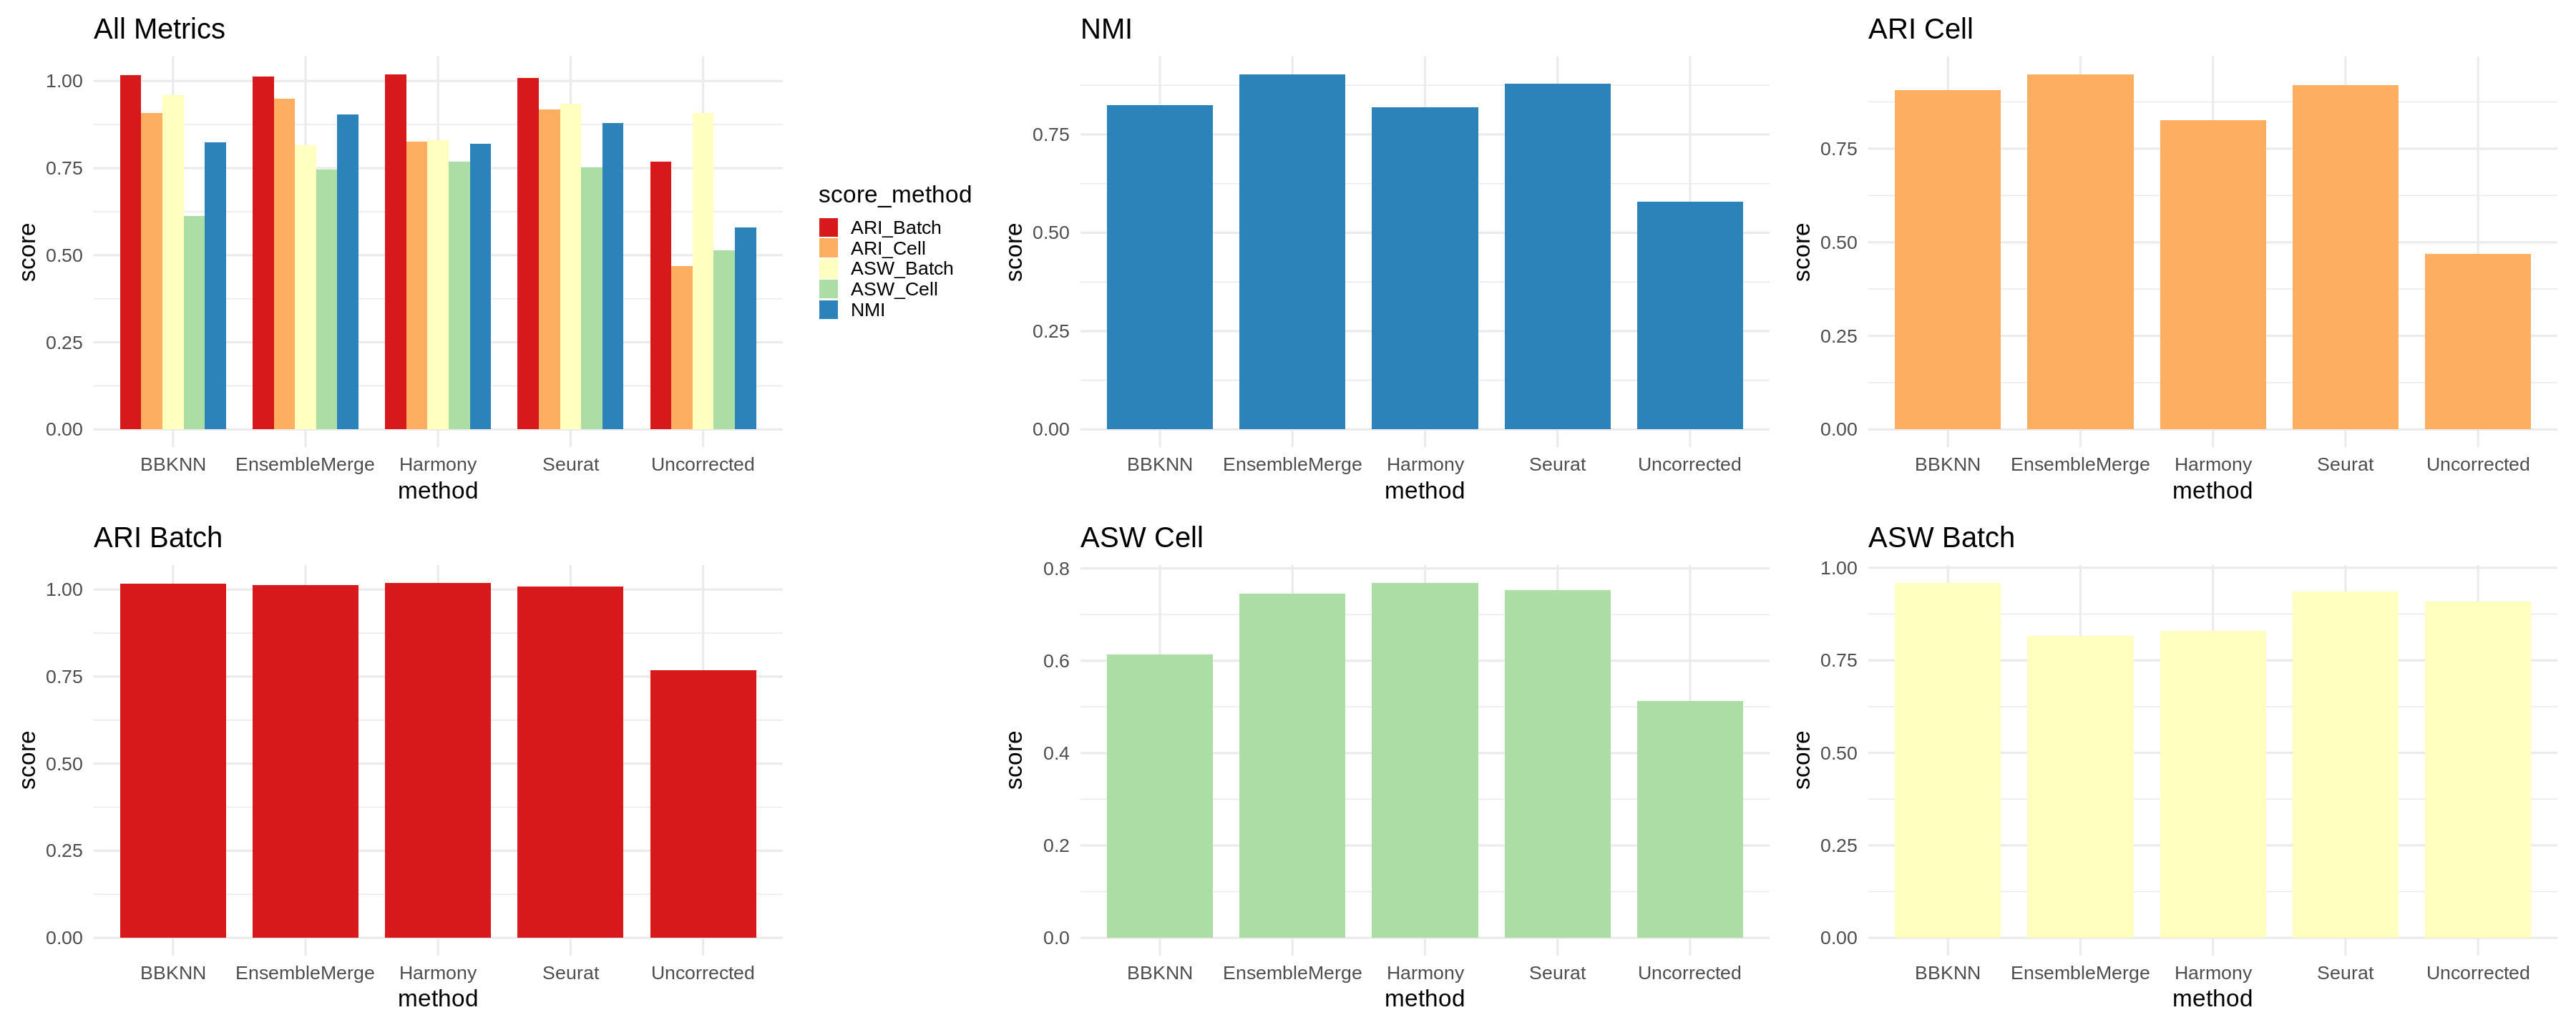

In [ ]:
#@title plot barplot scoring metrics
options(repr.plot.width = 30, repr.plot.height = 12)
p1 = ggplot(data = scores, aes(x = method, y = score, fill = score_method)) + geom_bar(stat = "identity", position=position_dodge(), width = 0.8) + scale_fill_brewer(palette="Spectral") + theme_minimal(base_size=20) + ggtitle((label = "All Metrics"))
p2 = ggplot(data = nmi_list, aes(x = method, y = score)) + geom_bar(stat = "identity", position=position_dodge(), width = 0.8, fill = "#2B83BA") + theme_minimal(base_size=20) + ggtitle((label = "NMI"))
p3 = ggplot(data = ari_cell_list, aes(x = method, y = score)) + geom_bar(stat = "identity", position=position_dodge(), width = 0.8, fill = "#FDAE61") + theme_minimal(base_size=20) + ggtitle((label = "ARI Cell"))
p4 = ggplot(data = ari_batch_list, aes(x = method, y = score)) + geom_bar(stat = "identity", position=position_dodge(), width = 0.8, fill = "#D7191C") + theme_minimal(base_size=20) + ggtitle((label = "ARI Batch"))
p5 = ggplot(data = asw_cell_list, aes(x = method, y = score)) + geom_bar(stat = "identity", position=position_dodge(), width = 0.8, fill = "#ABDDA4") + theme_minimal(base_size=20) + ggtitle((label = "ASW Cell"))
p6 = ggplot(data = asw_batch_list, aes(x = method, y = score)) + geom_bar(stat = "identity", position=position_dodge(), width = 0.8, fill = "#FFFFBF") + theme_minimal(base_size=20) + ggtitle((label = "ASW Batch"))
p1 + p2 + p3 + p4 + p5 + p6

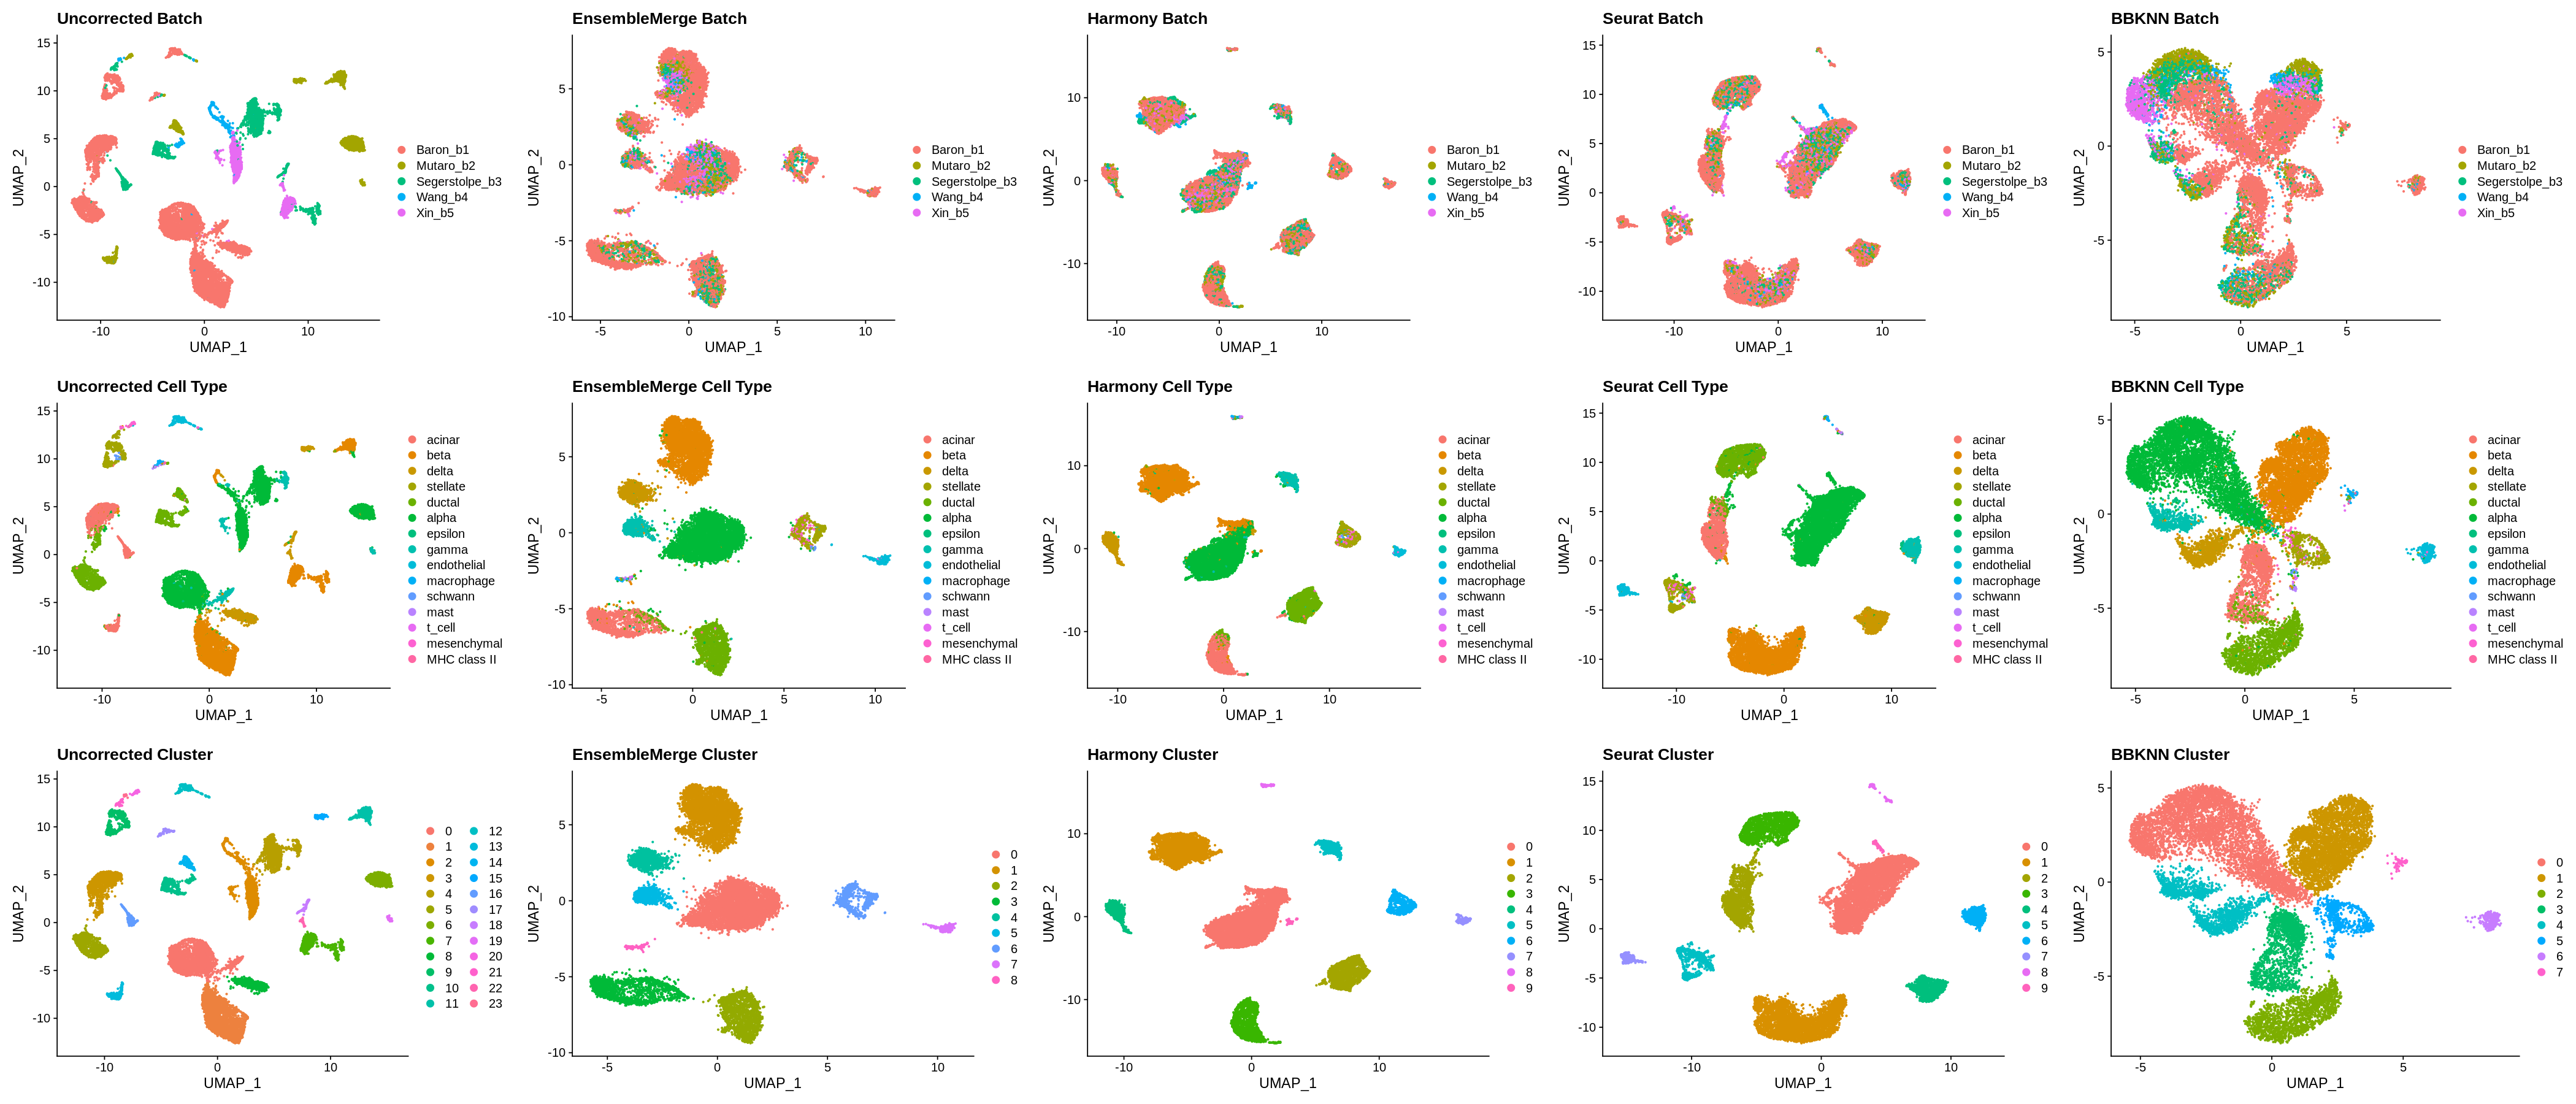

In [ ]:
#@title integration UMAP
options(repr.plot.width = 35, repr.plot.height = 15)
Seurat::Idents(uncorrected) = "batchlb"
p1 <- Seurat::DimPlot(uncorrected, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Uncorrected Batch")
Seurat::Idents(uncorrected) = "CellType"
p2 <- Seurat::DimPlot(uncorrected, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Uncorrected Cell Type")
Seurat::Idents(uncorrected) = "cluster"
p3 <- Seurat::DimPlot(uncorrected, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Uncorrected Cluster")
Seurat::Idents(test) = "batchlb"
p4 <- Seurat::DimPlot(test, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "EnsembleMerge Batch")
Seurat::Idents(test) = "CellType"
p5 <- Seurat::DimPlot(test, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "EnsembleMerge Cell Type")
Seurat::Idents(test) = "seurat_clusters"
p6 <- Seurat::DimPlot(test, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "EnsembleMerge Cluster")
Seurat::Idents(Harmony) = "batchlb"
p7 <- Seurat::DimPlot(Harmony, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Harmony Batch")
Seurat::Idents(Harmony) = "CellType"
p8 <- Seurat::DimPlot(Harmony, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Harmony Cell Type")
Seurat::Idents(Harmony) = "cluster"
p9 <- Seurat::DimPlot(Harmony, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Harmony Cluster")
Seurat::Idents(Seurat) = "batchlb"
p10 <- Seurat::DimPlot(Seurat, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Seurat Batch")
Seurat::Idents(Seurat) = "CellType"
p11 <- Seurat::DimPlot(Seurat, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Seurat Cell Type")
Seurat::Idents(Seurat) = "cluster"
p12 <- Seurat::DimPlot(Seurat, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Seurat Cluster")
Seurat::Idents(BBKNN) = "batchlb"
p13 <- Seurat::DimPlot(BBKNN, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "BBKNN Batch")
Seurat::Idents(BBKNN) = "CellType"
p14 <- Seurat::DimPlot(BBKNN, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "BBKNN Cell Type")
Seurat::Idents(BBKNN) = "cluster"
p15 <- Seurat::DimPlot(BBKNN, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "BBKNN Cluster")
ggarrange(p1,p4,p7,p10,p13,p2,p5,p8,p11,p14,p3,p6,p9,p12,p15,
          ncol = 5, nrow = 3)

The list of available integration methods is available with `getMethods()`

Additional Documentation is available [online](https://erikjskie.github.io/packages/ensemblemerge/index.html)

In [ ]:
getMethods()

[1] "Seurat"      "Harmony"     "Liger"       "Scanorama"   "BBKNN"      
[6] "fastMNN"     "Uncorrected" "scVI"

In [ ]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0                ggplot2_3.3.5              
 [3] magrittr_2.0.1              SeuratWrappers_0.3.0       
 [5] dplyr_1.0.7                 SeuratObject_4.0.3         
 [7] Seurat_4.0.5                scmetrics_0.0.02           
 [9] SingleC